In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, plot_coverage
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset,StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
config = Configuration()
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')
population_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/PopulationVector.csv", sep=',')
neighbourhood_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/AdjacentMatrix.csv", sep=',')

# WITHOUT FEATURES

In [2]:
locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
one_ts_df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date']]
one_ts_df = preprocessing(config, one_ts_df, check_count=False, output_type="corrected_df")

#seperate the intervals for training and testing
train_set = one_ts_df.loc[(one_ts_df.index <= config.train_end_time) & (one_ts_df.index >= config.train_start_time), :]
test_set = one_ts_df.loc[(one_ts_df.index >= config.train_start_time) & (one_ts_df.index <= config.test_end_time), :]
start_time = min(test_set.index.difference(train_set.index))
end_time = max(test_set.index.difference(train_set.index))
#Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set, item_id='location', target="value", freq=config.freq)
test_set = PandasDataset.from_long_dataframe(dataframe=test_set, item_id='location', target="value", freq=config.freq)

test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy=StepStrategy(prediction_length=4,step_size=1),
                                    start_time=pd.Period(start_time,config.freq),
                                    end_time=pd.Period(end_time,config.freq)
                                    )

In [3]:
'''
#train and evaluate the model
forecasts, tss = model(config, train_set, test_set, config.deeparestimator)
windows_per_location = int(len(test_set) / len(locations))
for location in locations[:10]:
    #plot the forecasts
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    #first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((one_ts_df.loc[(one_ts_df['location'] == location) &
                            (one_ts_df.index <= config.test_end_time) &
                            (one_ts_df.index >= config.train_end_time)].index),
             one_ts_df.loc[(one_ts_df['location'] == location) &
                           (one_ts_df.index <= config.test_end_time) &
                           (one_ts_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
    #define the colors to use for each different window
    color = ['g', 'r', 'purple', 'black', 'yellow', 'grey'] * windows_per_location
    for k in range(0 + windows_per_location * locations.index(location),
                   windows_per_location + windows_per_location * locations.index(location)):
        ts_entry = tss[k]
        forecast_entry = forecasts[k]
        prediction_intervals = (50.0, 90.0)
        legend = ['train_set observations',"median prediction"] +\
                [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()'''

'\n#train and evaluate the model\nforecasts, tss = model(config, train_set, test_set, config.deeparestimator)\nwindows_per_location = int(len(test_set) / len(locations))\nfor location in locations[:10]:\n    #plot the forecasts\n    fig, ax = plt.subplots(1, 1, figsize=(10, 7))\n    plt.title(f\'{location}\')\n    #first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)\n    plt.plot((one_ts_df.loc[(one_ts_df[\'location\'] == location) &\n                            (one_ts_df.index <= config.test_end_time) &\n                            (one_ts_df.index >= config.train_end_time)].index),\n             one_ts_df.loc[(one_ts_df[\'location\'] == location) &\n                           (one_ts_df.index <= config.test_end_time) &\n                           (one_ts_df.index >= config.train_end_time), \'value\'])\n    plt.grid(which="both")\n    #define the colors to use for each different window\n    color = [\'g\', \'r\', \'purple\', \'black\', \'yellow\', \'grey\']

100%|██████████| 50/50 [00:06<00:00,  8.25it/s, epoch=4/4, avg_epoch_loss=0.807]
Running evaluation: 411it [00:01, 321.71it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 325.13it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 316.17it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 319.82it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
 

{'DeepAR':                       item_id         forecast_start          MSE  abs_error  \
0            LK Ahrweiler {1}  2018-01-22/2018-01-28    65.934887      295.0   
1    LK Aichach-Friedberg {1}  2018-01-22/2018-01-28    14.232523      143.0   
2      LK Alb-Donau-Kreis {1}  2018-01-22/2018-01-28   184.367328      429.0   
3     LK Altenburger Land {1}  2018-01-22/2018-01-28   477.060768      679.0   
4         LK Altenkirchen {1}  2018-01-22/2018-01-28    29.065835      173.0   
..                        ...                    ...          ...        ...   
407          SK Wuppertal {4}  2018-01-22/2018-01-28   273.077581      557.0   
408           SK Würzburg {4}  2018-01-22/2018-01-28   137.402636      430.0   
409        SK Zweibrücken {4}  2018-01-22/2018-01-28    78.453784      350.0   
410   StädteRegion Aachen {4}  2018-01-22/2018-01-28   857.897713      834.0   
0              aggregated {4}                    NaT  1527.675763   407302.0   

     abs_target_sum  abs_tar

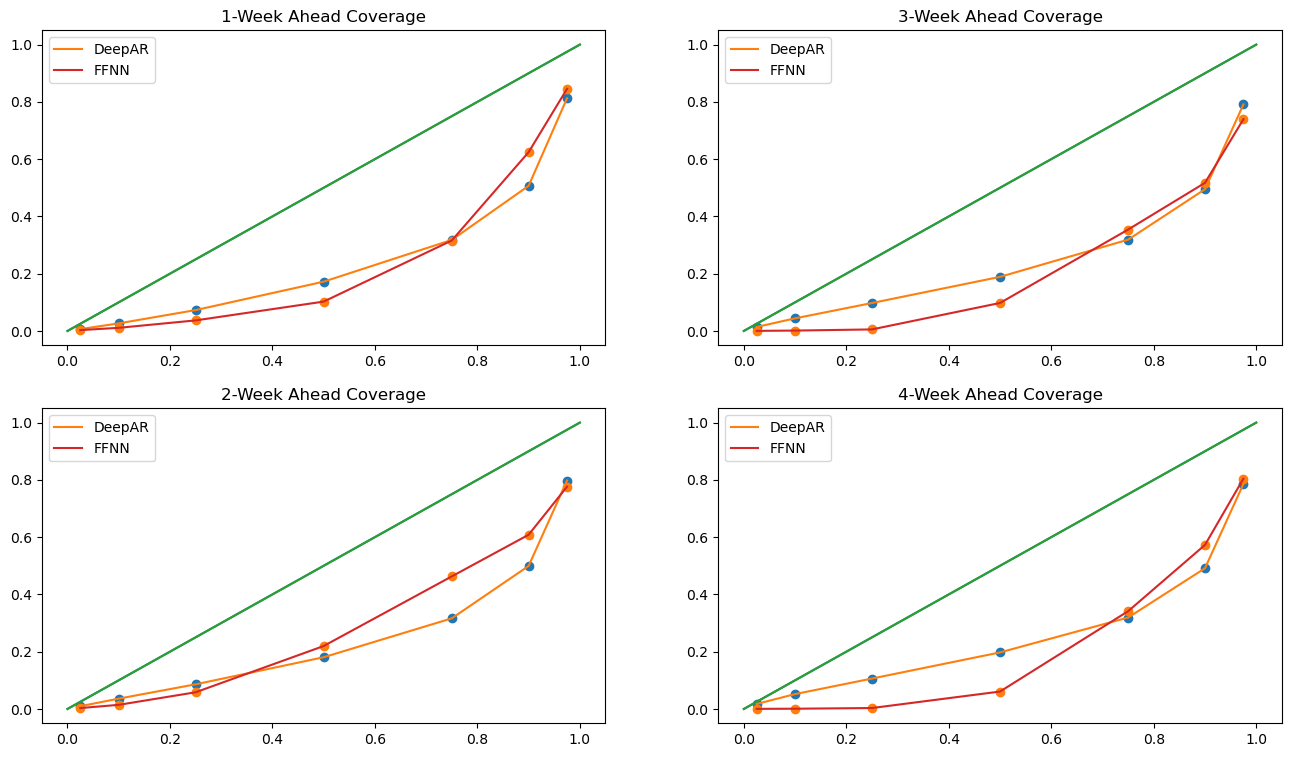

In [4]:
models_dict = {"DeepAR":config.deeparestimator, "FFNN":config.feedforwardestimator}
evaluator_df_dict = {}
for key in models_dict.keys():
    forecasts, tss = model(config, train_set, test_set, models_dict[key])

    # Splitting the forecasts into their weekly contribution
    split_tss = split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[1]

    forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                    2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                    3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                    4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
    # Evaluation
    evaluator = Evaluator(quantiles=config.quantiles)
    evaluator_df = pd.DataFrame()
               
    # iterate over the 4 different week-aheads
    for forecast in forecast_dict.values():
        agg_metrics, item_metrics = evaluator(split_tss, forecast)
        d = {key for key in forecast_dict if forecast_dict[key] == forecast}
        for location in locations[:]:
            item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
            evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
        agg_metrics["item_id"] = f"aggregated {d}"
        evaluator_df = pd.concat([evaluator_df, pd.DataFrame(agg_metrics,index=[0])])
    evaluator_df_dict[key] = evaluator_df
plot_coverage(config, evaluator_df_dict)
print(evaluator_df_dict)

# WITH FEATURES

In [5]:
locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
one_ts_df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date']]
one_ts_df = preprocessing(config, one_ts_df, check_count=False, output_type="corrected_df")
for location in locations:
    one_ts_df.loc[one_ts_df.location == location, "population"] = int(population_df.loc[population_df.Location == location, "2011"].values[0])
#seperate the intervals for training and testing
train_set = one_ts_df.loc[(one_ts_df.index <= config.train_end_time) & (one_ts_df.index >= config.train_start_time), :]
test_set = one_ts_df.loc[(one_ts_df.index >= config.train_start_time) & (one_ts_df.index <= config.test_end_time), :]
start_time = min(test_set.index.difference(train_set.index))
end_time = max(test_set.index.difference(train_set.index))
#Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set, item_id='location', target="value", freq=config.freq, feat_static_real=["population"])
test_set = PandasDataset.from_long_dataframe(dataframe=test_set, item_id='location', target="value", freq=config.freq, feat_static_real=["population"])

test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy=StepStrategy(prediction_length=4,step_size=1),
                                    start_time=pd.Period(start_time,config.freq),
                                    end_time=pd.Period(end_time,config.freq)
                                    )

In [6]:
'''
#train and evaluate the model
forecasts, tss = model(config, train_set, test_set, config.deeparestimator)
windows_per_location = int(len(test_set) / len(locations))
for location in locations[:10]:
    #plot the forecasts
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    #first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((one_ts_df.loc[(one_ts_df['location'] == location) &
                            (one_ts_df.index <= config.test_end_time) &
                            (one_ts_df.index >= config.train_end_time)].index),
             one_ts_df.loc[(one_ts_df['location'] == location) &
                           (one_ts_df.index <= config.test_end_time) &
                           (one_ts_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
    #define the colors to use for each different window
    color = ['g', 'r', 'purple', 'black', 'yellow', 'grey'] * windows_per_location
    for k in range(0 + windows_per_location * locations.index(location),
                   windows_per_location + windows_per_location * locations.index(location)):
        ts_entry = tss[k]
        forecast_entry = forecasts[k]
        prediction_intervals = (50.0, 90.0)
        legend = ['train_set observations',"median prediction"] +\
                [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()'''

'\n#train and evaluate the model\nforecasts, tss = model(config, train_set, test_set, config.deeparestimator)\nwindows_per_location = int(len(test_set) / len(locations))\nfor location in locations[:10]:\n    #plot the forecasts\n    fig, ax = plt.subplots(1, 1, figsize=(10, 7))\n    plt.title(f\'{location}\')\n    #first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)\n    plt.plot((one_ts_df.loc[(one_ts_df[\'location\'] == location) &\n                            (one_ts_df.index <= config.test_end_time) &\n                            (one_ts_df.index >= config.train_end_time)].index),\n             one_ts_df.loc[(one_ts_df[\'location\'] == location) &\n                           (one_ts_df.index <= config.test_end_time) &\n                           (one_ts_df.index >= config.train_end_time), \'value\'])\n    plt.grid(which="both")\n    #define the colors to use for each different window\n    color = [\'g\', \'r\', \'purple\', \'black\', \'yellow\', \'grey\']

100%|██████████| 50/50 [00:05<00:00,  9.15it/s, epoch=4/4, avg_epoch_loss=0.821]
Running evaluation: 411it [00:01, 268.21it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 251.45it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 268.42it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 269.93it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
 

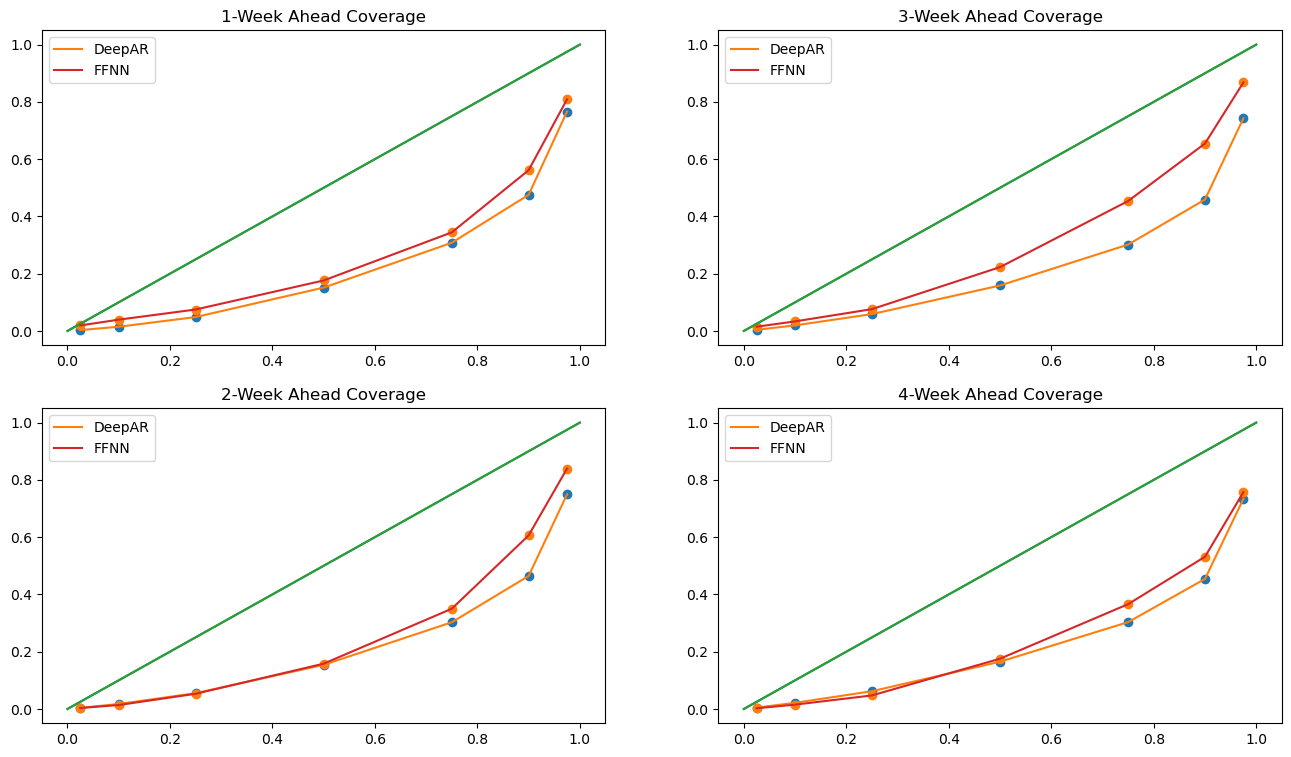

In [7]:
models_dict = {"DeepAR":config.deeparestimator, "FFNN":config.feedforwardestimator}
evaluator_df_dict = {}
for key in models_dict.keys():
    forecasts, tss = model(config, train_set, test_set, models_dict[key])

    # Splitting the forecasts into their weekly contribution
    split_tss = split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[1]

    forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                    2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                    3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                    4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
    # Evaluation
    evaluator = Evaluator(quantiles=config.quantiles)
    evaluator_df = pd.DataFrame()
               
    # iterate over the 4 different week-aheads
    for forecast in forecast_dict.values():
        agg_metrics, item_metrics = evaluator(split_tss, forecast)
        d = {key for key in forecast_dict if forecast_dict[key] == forecast}
        for location in locations[:]:
            item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
            evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
        agg_metrics["item_id"] = f"aggregated {d}"
        evaluator_df = pd.concat([evaluator_df, pd.DataFrame(agg_metrics,index=[0])])
    evaluator_df_dict[key] = evaluator_df
plot_coverage(config, evaluator_df_dict)

In [8]:
print(evaluator_df_dict)

{'DeepAR':                       item_id         forecast_start          MSE  abs_error  \
0            LK Ahrweiler {1}  2018-01-22/2018-01-28    54.123978      263.0   
1    LK Aichach-Friedberg {1}  2018-01-22/2018-01-28    13.116575      135.0   
2      LK Alb-Donau-Kreis {1}  2018-01-22/2018-01-28   159.751923      403.0   
3     LK Altenburger Land {1}  2018-01-22/2018-01-28   437.447447      670.0   
4         LK Altenkirchen {1}  2018-01-22/2018-01-28    27.619853      163.0   
..                        ...                    ...          ...        ...   
407          SK Wuppertal {4}  2018-01-22/2018-01-28   316.723864      595.0   
408           SK Würzburg {4}  2018-01-22/2018-01-28   114.099358      390.0   
409        SK Zweibrücken {4}  2018-01-22/2018-01-28    62.480142      281.0   
410   StädteRegion Aachen {4}  2018-01-22/2018-01-28   865.028431      894.0   
0              aggregated {4}                    NaT  1430.689835   359820.0   

     abs_target_sum  abs_tar